<a href="https://colab.research.google.com/github/Vinayak0042/ML-for-detecting-DON-concentration-/blob/main/ImagoAI_%7C_MLE_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

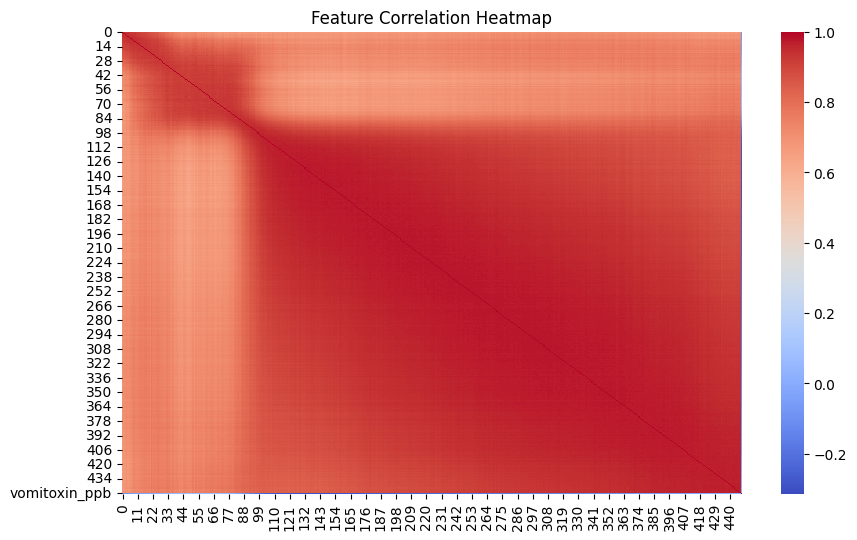

               Model          MAE          RMSE  R2 Score
0  Linear Regression  4002.938164   9052.741909  0.706825
1     Neural Network  4244.154585  14761.344205  0.220496
2      Random Forest  1819.462865   3858.856586  0.946730
3  Gradient Boosting  1844.506287   3985.779771  0.943168
4  Stacking Ensemble  1848.847104   3736.000408  0.950068


ExactExplainer explainer: 101it [00:21,  2.43it/s]


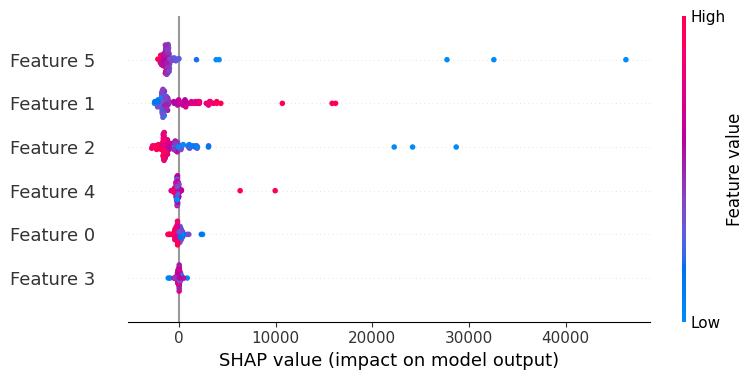

In [11]:
import pandas as pd
import numpy as np
import logging
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from scipy.stats import zscore
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import shap
import pickle

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

def load_data(filepath):
    """Load CSV data into a Pandas DataFrame."""
    try:
        df = pd.read_csv(filepath)
        df.set_index('hsi_id', inplace=True)
        logging.info("Data loaded successfully.")
        return df
    except Exception as e:
        logging.error(f"Error loading data: {e}")
        return None

def explore_data(df):
    """Perform exploratory data analysis with visualizations."""
    try:
        plt.figure(figsize=(10, 6))
        sns.heatmap(df.corr(), cmap='coolwarm', annot=False)
        plt.title("Feature Correlation Heatmap")
        plt.show()
    except Exception as e:
        logging.error(f"Error in data exploration: {e}")

def scale_features(df):
    """Apply StandardScaler on all columns except 'vomitoxin_ppb'."""
    try:
        scaler = StandardScaler()
        columns_to_scale = [col for col in df.columns if col != 'vomitoxin_ppb']
        df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])
        logging.info("Feature scaling applied successfully.")
        return df, scaler
    except Exception as e:
        logging.error(f"Error in feature scaling: {e}")
        return None, None

def interpret_model(model, X_train):
    """Use SHAP to interpret the best model's predictions."""
    try:
        explainer = shap.Explainer(model.predict, X_train)
        shap_values = explainer(X_train)
        shap.summary_plot(shap_values, X_train)
        logging.info("SHAP interpretation completed for best model.")
    except Exception as e:
        logging.error(f"Error in model interpretation: {e}")

def apply_pca(X, variance_threshold=0.95):
    """Apply PCA for dimensionality reduction."""
    try:
        pca = PCA(n_components=variance_threshold)
        X_pca = pca.fit_transform(X)
        logging.info(f"PCA applied. Number of components: {X_pca.shape[1]}")
        return X_pca, pca
    except Exception as e:
        logging.error(f"Error in PCA: {e}")
        return None, None

def feature_engineering(X):
    """Generate polynomial features to enhance model performance."""
    try:
        poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
        X_poly = poly.fit_transform(X)
        logging.info("Feature engineering applied successfully.")
        return X_poly, poly
    except Exception as e:
        logging.error(f"Error in feature engineering: {e}")
        return None, None

def tune_random_forest(X_train, y_train):
    """Perform hyperparameter tuning on Random Forest."""
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5]
    }
    rf = RandomForestRegressor(random_state=42)
    grid_search = GridSearchCV(rf, param_grid, cv=3, scoring='r2', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    logging.info(f"Best Random Forest parameters: {grid_search.best_params_}")
    return grid_search.best_estimator_

def train_models(X_train, y_train):
    """Train models including a Stacking Ensemble."""
    base_models = [
        ('Random Forest', tune_random_forest(X_train, y_train)),
        ('Gradient Boosting', GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42))
    ]

    models = {
        "Linear Regression": LinearRegression(),
        "Neural Network": MLPRegressor(hidden_layer_sizes=(32, 16), activation='relu', solver='adam', max_iter=3000, learning_rate_init=0.0005, early_stopping=True, random_state=42),
        "Random Forest": base_models[0][1],
        "Gradient Boosting": base_models[1][1],
        "Stacking Ensemble": StackingRegressor(estimators=base_models, final_estimator=LinearRegression())
    }

    trained_models = {}
    for name, model in models.items():
        try:
            model.fit(X_train, y_train)
            trained_models[name] = model
            logging.info(f"{name} training completed.")
        except Exception as e:
            logging.error(f"Error in {name} training: {e}")
    return trained_models

def evaluate_models(models, X_test, y_test, scaler, poly, pca):
    """Evaluate models and display results in a table format. Interpret only the best model and save best model and scaler."""
    results = []
    best_model_name = ""
    best_r2 = float('-inf')
    best_model = None

    for name, model in models.items():
        try:
            y_pred = model.predict(X_test)
            mae = mean_absolute_error(y_test, y_pred)
            rmse = np.sqrt(mean_squared_error(y_test, y_pred))
            r2 = r2_score(y_test, y_pred)
            results.append([name, mae, rmse, r2])
            logging.info(f"{name} - MAE: {mae}, RMSE: {rmse}, R2 Score: {r2}")

            if r2 > best_r2:
                best_r2 = r2
                best_model = model
                best_model_name = name
        except Exception as e:
            logging.error(f"Error in {name} evaluation: {e}")

    results_df = pd.DataFrame(results, columns=["Model", "MAE", "RMSE", "R2 Score"])
    print(results_df)

    if best_model:
        logging.info(f"Interpreting the best model: {best_model_name}")
        interpret_model(best_model, X_test)

        # Save best model, scaler, poly, and pca
        with open('best_model.pkl', 'wb') as file:
            pickle.dump(best_model, file)
        with open('scaler.pkl', 'wb') as file:
            pickle.dump(scaler, file)
        with open('poly.pkl', 'wb') as file:
            pickle.dump(poly, file)
        with open('pca.pkl', 'wb') as file:
            pickle.dump(pca, file)
        logging.info("Best model, scaler, poly, and pca saved.")

if __name__ == "__main__":
    data = load_data("/content/MLE-Assignment.csv")
    if data is not None:
        explore_data(data)
        data, scaler = scale_features(data)
        if data is not None:
            X = data.drop('vomitoxin_ppb', axis=1)
            y = data['vomitoxin_ppb']
            X_pca, pca = apply_pca(X)
            X_fe, poly = feature_engineering(X_pca)
            X_train, X_test, y_train, y_test = train_test_split(X_fe, y, test_size=0.2, random_state=42)
            models = train_models(X_train, y_train)
            evaluate_models(models, X_test, y_test, scaler, poly, pca)